# Women's E-commerce Clothing Reviews 

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# sklearn :: models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
#import xgboost

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

# Problem definition

Apply ML Classification models to predict customer feed back (Sentiment) positive or negative


In [2]:
# Load the data
df = pd.read_csv("../data/Cleaned-womens-ecommerce-clothing-reviews.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22628 entries, 0 to 22627
Data columns (total 11 columns):
Clothing ID                22628 non-null int64
Age                        22628 non-null int64
Title                      22628 non-null object
Review Text                22628 non-null object
Rating                     22628 non-null int64
Recommendation             22628 non-null int64
Positive Feedback Count    22628 non-null int64
Division Name              22628 non-null object
Product Category           22628 non-null object
clothes type               22628 non-null object
reviews                    22628 non-null object
dtypes: int64(5), object(6)
memory usage: 1.9+ MB


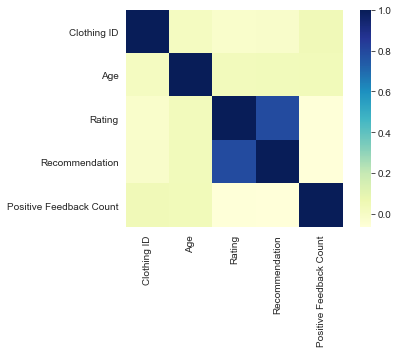

In [4]:
##Check co relation between the variables
corrmat = df.corr()
sns.heatmap(corrmat,square=True, cmap="YlGnBu");

From above plot we can see variables are strongly corelated with itslef and strong relationship found between rating and recommendation.

 # Building a Sentiment Classifier
ince we do not have a column which shows the sentiment as positive or negative in the dataset, I defined a new customer feedback column. 
I assumed that:
- Rating of 4 or higher as a positive (True in the new dataframe), while the ones with 
- Rating of 2 or lower as a negative (False in the new dataframe)
- Rating of 3 as a neutral no need to include this in the new dataframe

In [5]:
df = df[df['Rating'] != 3]
df['customer feedback'] = df['Rating'] >=4
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommendation,Positive Feedback Count,Division Name,Product Category,clothes type,reviews,customer feedback
0,767,33,Love it!,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Love it! - Absolutely wonderful - silky and se...,True
1,1080,34,Love it!,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love it! - Love this dress! it's sooo pretty....,True
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! - I love, love, love this jum...",True
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt - This shirt is very flatteri...,True
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,Not for the very petite - I love tracy reese d...,False


# Model Training:

In [6]:
# feature engineering

X = df['Review Text']
y = df['customer feedback']


# Create training and test sets and split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=53)


print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (13269,)
y_train (13269,)
X_test (6536,)
y_test (6536,)


In order to perform machine learning on text, I have to extract features from text by converting the text I have to word count vectors with CountVectorizer.
So that I first need to turn the text content into numerical feature vectors by using a bags of words representation:


In [7]:
# Initialize a CountVectorizer object
count_vectorizer = CountVectorizer (stop_words='english', ngram_range=(1,2), min_df=0.001, max_df=0.999)

# Initialize a TfidfVectorizer object
# In text mining, the term frequency – inverse document frequency (tf-idf), is a well know method to evaluate how important is a word in a document. tf-idf is a very interesting way to convert the textual representation of information into a Vector Space Model (VSM),
# To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

# Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

# This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)


# Transform the training data 
count_train = count_vectorizer.fit_transform (X_train)
count_train = count_train.toarray()

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_train = tfidf_train.toarray()


# Transform the test data
count_test = count_vectorizer.transform (X_test)
count_test = count_test.toarray()

tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_test = tfidf_test.toarray()


print('Vocabulary len :', len(count_vectorizer.get_feature_names()))
print('Longest word   :', max(count_vectorizer.vocabulary_, key=len))

Vocabulary len : 4261
Longest word   : compliments comfortable



# Training a classifier Model

Now that I have the features, we can train a classifier (clf) to try to predict the customer feedback category (positive or negative). 
let’s start with a:

## Naive Bayes Classifier:

In [8]:
# Instantiate a Multinomial Naive Bayes
nb_classifier = MultinomialNB()

#Use GridSearchCV to obtain best parameters

alphas = np.arange(0,1,0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0


/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.9007037943696451

Alpha:  0.1
Score:  0.9077417380660955

Alpha:  0.2
Score:  0.9031517747858017

Alpha:  0.30000000000000004
Score:  0.8982558139534884

Alpha:  0.4
Score:  0.8951958384332925

Alpha:  0.5
Score:  0.8912178702570379

Alpha:  0.6000000000000001
Score:  0.8884638922888617

Alpha:  0.7000000000000001
Score:  0.8863219094247246

Alpha:  0.8
Score:  0.8846389228886169

Alpha:  0.9
Score:  0.8841799265605875



In [9]:
# Fit the classifier to the training data using tfidf
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(tfidf_train, y_train)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

# Create the predicted tags
pred = nb_classifier.predict(tfidf_test)


# Calculate the accuracy score
metrics.accuracy_score(y_test, pred)

print('AUC: ', roc_auc_score(y_test, pred))

AUC:  0.617221446425275


In [10]:
# Calculate the confusion matrix
metrics.confusion_matrix(y_test, pred)

array([[ 182,  583],
       [  20, 5751]])

In [11]:
# Fit the classifier to the training data using count vectorizer
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(count_train, y_train)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


# Create the predicted tags
pred = nb_classifier.predict(count_test)


# Calculate the accuracy score
metrics.accuracy_score(y_test, pred)

print('AUC: ', roc_auc_score(y_test, pred))

AUC:  0.8534942007762498


We obtained a better score with count vectorizer comparing tfidf


In [12]:
# Calculate the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, pred)
conf_mat

array([[ 583,  182],
       [ 318, 5453]])

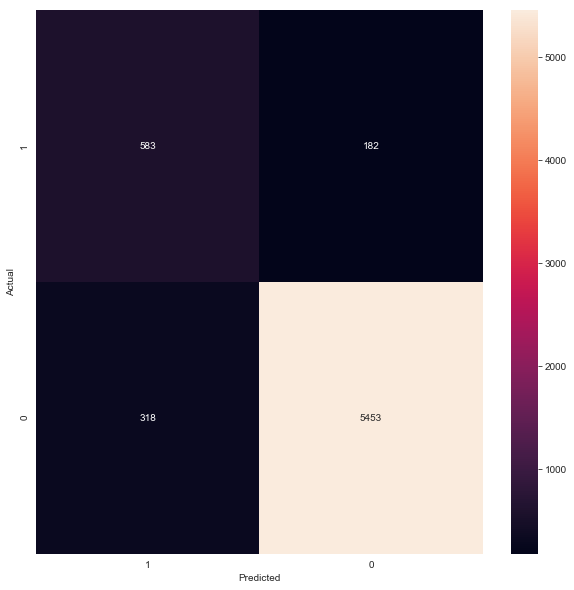

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['1','0'], yticklabels=['1','0'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Get the class labels: class_labels
class_labels = nb_classifier.classes_


# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()


# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Model Training / Evaluation

In [14]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0 ),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

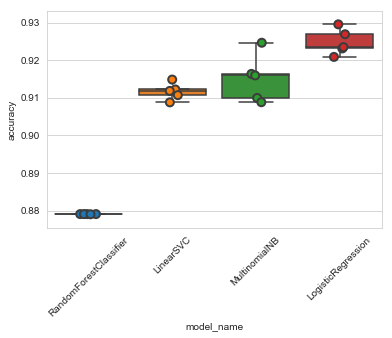

In [15]:
entries = []
features = count_train
labels = y_train
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.911674
LogisticRegression        0.924787
MultinomialNB             0.915141
RandomForestClassifier    0.879041
Name: accuracy, dtype: float64

best accuracy with Logistic Regression

### LogisticRegression

In [17]:
logreg_CV = LogisticRegression(C=5.0,random_state=5, dual=True, penalty="l2")
logreg_CV.fit(count_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_test)
print(metrics.classification_report(y_test, y_pred_lr_CV))
print('Accuracy : ', metrics.accuracy_score(y_test, y_pred_lr_CV))

/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

       False       0.70      0.64      0.67       765
        True       0.95      0.96      0.96      5771

   micro avg       0.93      0.93      0.93      6536
   macro avg       0.83      0.80      0.81      6536
weighted avg       0.92      0.93      0.92      6536

Accuracy :  0.9261015911872705


/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Multi nomial NB

In [18]:
multiNB = MultinomialNB()
multiNB.fit(count_train, y_train)
y_pred_NB = multiNB.predict(count_test)
print(metrics.classification_report(y_test, y_pred_NB))
print('Accuracy : ', metrics.accuracy_score(y_test, y_pred_NB))

              precision    recall  f1-score   support

       False       0.63      0.79      0.70       765
        True       0.97      0.94      0.95      5771

   micro avg       0.92      0.92      0.92      6536
   macro avg       0.80      0.86      0.83      6536
weighted avg       0.93      0.92      0.92      6536

Accuracy :  0.9204406364749081


### Linear SVC

In [19]:
linear_SVC = LinearSVC()
linear_SVC.fit(count_train, y_train)
y_pred_linSVC = linear_SVC.predict(count_test)
print(metrics.classification_report(y_test, y_pred_linSVC))
print('Accuracy : ', metrics.accuracy_score(y_test, y_pred_linSVC))

              precision    recall  f1-score   support

       False       0.63      0.65      0.64       765
        True       0.95      0.95      0.95      5771

   micro avg       0.91      0.91      0.91      6536
   macro avg       0.79      0.80      0.80      6536
weighted avg       0.92      0.91      0.92      6536

Accuracy :  0.9147796817625459


### Random Forest

In [20]:
RF_CLF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
RF_CLF.fit(count_train, y_train)
y_pred_RF = RF_CLF.predict(count_test)
print(metrics.classification_report(y_test, y_pred_RF))
print('Accuracy : ', metrics.accuracy_score(y_test, y_pred_RF))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       765
        True       0.88      1.00      0.94      5771

   micro avg       0.88      0.88      0.88      6536
   macro avg       0.44      0.50      0.47      6536
weighted avg       0.78      0.88      0.83      6536

Accuracy :  0.8829559363525091


/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
